In [ ]:
### Soft Actor-Critic

In [ ]:
!pip install roboschool==1.0.48 gym==0.15.4

In [1]:
import cv2
import matplotlib.pyplot as plt

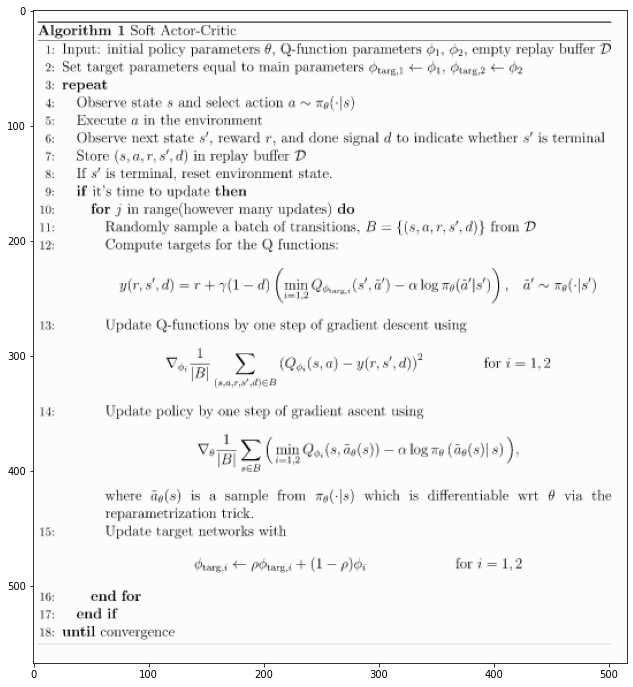

In [2]:
img=cv2.imread("SAC.png")
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import gym
import roboschool

In [ ]:
import tensorflow_probability as tfp

In [ ]:
env = gym.make('RoboschoolInvertedPendulum-v1')

In [ ]:
state_dimension=env.observation_space.shape

In [ ]:
action_dimension=env.action_space.shape[0]

In [ ]:
def get_critic():

  input_state=tf.keras.layers.Input(state_dimension)
  input_action=tf.keras.layers.Input(action_dimension)
  layer_1=tf.keras.layers.concatenate([input_state,input_action],axis=-1)
  layer_2=tf.keras.layers.Dense(256,activation="relu")(layer_1)
  layer_3=tf.keras.layers.Dense(256,activation="relu")(layer_2)
  out_Q=tf.keras.layers.Dense(1,activation=None)(layer_3)

  model=tf.keras.Model(inputs=[input_state,input_action],outputs=[out_Q])
  return model

def get_actor():

  input=tf.keras.layers.Input(state_dimension)
  layer_1=tf.keras.layers.Dense(256,activation="relu")(input)
  layer_2=tf.keras.layers.Dense(256,activation="relu")(layer_1)
  mu=tf.keras.layers.Dense(action_dimension,activation=None)(layer_2)
  log_sigma=tf.keras.layers.Dense(action_dimension,activation=None)(layer_2)

  model=tf.keras.Model(inputs=[input],outputs=[mu,log_sigma])
  return model


In [ ]:
Train_actor=get_actor()
Train_critic_1=get_critic()
Target_critic_1=get_critic()
Target_critic_1.set_weights(Train_critic_1.get_weights())
Train_critic_2=get_critic()
Target_critic_2=get_critic()
Target_critic_2.set_weights(Train_critic_2.get_weights())

In [ ]:
from memory_module import replayBuffer
memory=replayBuffer(100000)

In [ ]:
MAX_CLIP_sigma=2
MIN_CLIP_sigma=-20

In [ ]:
def get_action(actor,s):
  mu,log_sigma=actor(s)
  sigma=tf.exp(tf.clip_by_value(log_sigma,MIN_CLIP_sigma,MAX_CLIP_sigma))
  dist=tfp.distributions.Normal(mu,sigma)
  action=dist.sample()
  bounded_action=tf.tanh(action)

  return action,bounded_action


In [ ]:
def get_log_prob(actor,s,a,bounded_a):
  mu,log_sigma=actor(s)
  sigma=tf.exp(tf.clip_by_value(log_sigma,MIN_CLIP_sigma,MAX_CLIP_sigma))
  dist=tfp.distributions.Normal(mu,sigma)
  log_pr=dist.log_prob(a)
  ### Modifying the log_pr for the action as mentioned in appendix c of the paper
  log_pr_mod=log_pr - tf.reduce_mean(tf.math.log(1-bounded_a**2+1e-8),axis=1,keepdims=True)

  return log_pr_mod

In [ ]:
def get_Q_value(critic,s,a):
  q=critic([s,a])
  return q

In [ ]:
def initialize_buffer():
    
    curr_state=env.reset()
    for _ in range(10000):
      action=env.action_space.sample()
      next_state,reward,done,_=env.step(action)
      memory.push(curr_state,action,reward,next_state,not done)

      if done:
        curr_state=env.reset()
      else:
        curr_state=next_state

In [ ]:
initialize_buffer()

In [ ]:
cr_1_opt=tf.keras.optimizers.Adam(0.0003)
cr_2_opt=tf.keras.optimizers.Adam(0.0003)
ac_opt=tf.keras.optimizers.Adam(0.0003)

In [ ]:
def update_networks(target_net,train_net,tau):
  weights_tar, weights_tra = target_net.get_weights(), train_net.get_weights()
  for i in range(len(weights_tar)):
    weights_tar[i] = tau*weights_tra[i] + (1-tau)*weights_tar[i]
  target_net.set_weights(weights_tar)

In [ ]:
def train():

  batch_size=256
  steps_to_train=1000000
  update_actor_step=2
  tau=0.005
  alpha=0.2
  gamma=0.99
  curr_state=env.reset()
  overall_Reward=0
  episode_reward=0
  no_of_comp=0

  for i in range(steps_to_train):
    
    action,b_action=get_action(Train_actor,curr_state.reshape(1,-1))
    next_state,reward,done,_=env.step(b_action.numpy()[0])
    episode_reward+=reward

    memory.push(curr_state,b_action,reward,next_state,not done)

    if done:

        curr_state=env.reset()
        overall_Reward+=episode_reward
        if no_of_comp%20==0:
          print('On step {}, no. of complete episodes {} average episode reward {}'.format(i,no_of_comp,overall_Reward/20))
          overall_Reward=0
        episode_reward=0  ### Updating the reward to 0
        no_of_comp+=1
   
    else:
      
      curr_state=next_state

    states, actions, rewards, next_states, not_dones = memory.sample(batch_size)

    with tf.GradientTape() as t1, tf.GradientTape() as t2:

      n_actions,b_n_actions=get_action(Train_actor,next_states)
      log_pr=get_log_prob(Train_actor,next_states,n_actions,b_n_actions)

      next_value_1=get_Q_value(Target_critic_1,next_states,b_n_actions)
      next_value_2=get_Q_value(Target_critic_2,next_states,b_n_actions)

      pred_value_1=(get_Q_value(Train_critic_1,np.array(states,dtype="float32"),np.array(actions,dtype="float32")))
      pred_value_2=(get_Q_value(Train_critic_2,np.array(states,dtype="float32"),np.array(actions,dtype="float32")))

      next_value=tf.math.minimum(next_value_1,next_value_2)

      target_value= rewards + gamma*(next_value - alpha * log_pr)*not_dones

      critic_loss_1=tf.reduce_mean(tf.math.squared_difference(target_value,pred_value_1))
      critic_loss_2=tf.reduce_mean(tf.math.squared_difference(target_value,pred_value_2))

    grad_crit_1=t1.gradient(critic_loss_1,Train_critic_1.trainable_variables)
    grad_crit_2=t2.gradient(critic_loss_2,Train_critic_2.trainable_variables)

    cr_1_opt.apply_gradients(zip(grad_crit_1,Train_critic_1.trainable_variables))
    cr_2_opt.apply_gradients(zip(grad_crit_2,Train_critic_2.trainable_variables))

    with tf.GradientTape() as t:

      n_actions,b_n_actions=get_action(Train_actor,states)
      log_pr_a=get_log_prob(Train_actor,states,n_actions,b_n_actions)

      state_value_1=get_Q_value(Train_critic_1,states,b_n_actions)
      state_value_2=get_Q_value(Train_critic_2,states,b_n_actions)

      value=tf.math.minimum(state_value_1,state_value_2) - alpha * log_pr_a

      act_loss= -1*tf.reduce_mean(value)

    grad_actor=t.gradient(act_loss,Train_actor.trainable_variables)
    ac_opt.apply_gradients(zip(grad_actor,Train_actor.trainable_variables))

    update_networks(Target_critic_1,Train_critic_1,tau)
    update_networks(Target_critic_2,Train_critic_2,tau)


In [ ]:
train()

/content/memory_module.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(s),np.array(a),np.array(r),np.array(s_),np.uint8(nd)


On step 22, no. of complete episodes 0 average episode reward 1.15
On step 454, no. of complete episodes 20 average episode reward 21.6
On step 937, no. of complete episodes 40 average episode reward 24.15
On step 1402, no. of complete episodes 60 average episode reward 23.25
On step 1898, no. of complete episodes 80 average episode reward 24.8
On step 2356, no. of complete episodes 100 average episode reward 22.9
On step 2780, no. of complete episodes 120 average episode reward 21.2
On step 3328, no. of complete episodes 140 average episode reward 27.4
On step 3851, no. of complete episodes 160 average episode reward 26.15
On step 4420, no. of complete episodes 180 average episode reward 28.45
On step 4959, no. of complete episodes 200 average episode reward 26.95
On step 5506, no. of complete episodes 220 average episode reward 27.35
On step 6116, no. of complete episodes 240 average episode reward 30.5
On step 6862, no. of complete episodes 260 average episode reward 37.3
On step 77